In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cvxopt
import itertools

## Implementation notes

In [2]:
## FILL IN HERE

## OC-SVM Class

In [3]:
class OC_SVM(object):
    
    def __init__(self, kernel = 'linear', degree = 3, sigma = 1, upsilon = None, alpha_threshold = 1e-5):
        
        self.kernel = kernel
        self.degree = degree #polynomial kernel degree
        self.sigma = sigma #Gaussian kernel 1/variance
        self.upsilon = upsilon
        self.alpha_threshold = alpha_threshold

    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)
    
    def polynomial_kernel(self, x1, x2):
        return (1 + np.dot(x1, x2)) **self.degree
    
    def gaussian_kernel(self, x1, x2):
        return np.exp(-1 * (np.linalg.norm(x1 - x2)**2) / self.sigma**2 )
    
    def apply_kernel_function(self, x1, x2):
        
        if self.kernel == 'linear':
            return self.linear_kernel(x1, x2)
        
        elif self.kernel == 'polynomial':
            return self.polynomial_kernel(x1, x2)
            
        elif self.kernel == 'gaussian':
            return self.gaussian_kernel(x1, x2)
        
        else:
            print("Illegal kernel function chosen.")
            raise SystemExit
    
    def calculate_gram(self, X):
        n, f = X.shape
        
        K = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                K[i, j] = self.apply_kernel_function(X[i, :], X[j, :])
        
        return K
    
    def calculate_max_dist(self, X):
        n, f = X.shape
        
        dist_mat = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                dist_mat[i, j] = np.linalg.norm(X[i, :] - X[j, :])**2
        
        return np.max(np.sqrt(dist_mat))
    
    def fit(self, X, y = None):

        #Determine gram matrix
        Gram = self.calculate_gram(X)
        n = Gram.shape[0]
        
        #Setup necessary matrices to be used for lagrangian multipliers
        #P and q
        
        P = cvxopt.matrix(Gram)
        q = cvxopt.matrix(np.zeros((n, 1)))

        G_1 = -1 * np.eye(n)
        h_1 = np.zeros((n, 1))

        G_2 = np.eye(n)
        h_2 = 1/(self.upsilon * n) * np.ones((n, 1))

        G = cvxopt.matrix(np.vstack((G_1, G_2)))
        h = cvxopt.matrix(np.vstack((h_1, h_2)))
        
        #A and b
        A = cvxopt.matrix(np.ones((1,  n)))
        b = cvxopt.matrix(np.ones((1, 1)))
        
        #We are now ready to solve the convex optimisation problem!
        self.solution = cvxopt.solvers.qp(P, q, G, h, A, b)  
        print(self.solution)
        
        #Save alphas
        self.alphas = np.array(self.solution['x'])[:, 0]
        
        #Setup index lists!
        support_alpha_indices = []
        
        for cnt, i in enumerate(self.alphas):
            if i >= self.alpha_threshold:
                #if self.C is not None:
                #     if i != self.C:
                #        support_alpha_indices.append(cnt)
                        
                #else:
                support_alpha_indices.append(cnt)
        
        self.support_alpha_indices = support_alpha_indices
        self.support_alphas = self.alphas[self.support_alpha_indices]
        self.support_vectors = X[self.support_alpha_indices, :]
        self.sv_weights = self.support_alphas #alpha_prime for sv's
        
        #Calculate hyperplane vector
        self.W = np.sum(self.support_alphas.reshape(-1, 1) * self.support_vectors, axis = 0)
        
        #Calculate rho
        sv_index = 0 #Use first support vector to compute radius
        actual_index = self.support_alpha_indices[sv_index]
        self.Gram_svs = self.calculate_gram(self.support_vectors)
        
        self.rho = np.dot(self.sv_weights, self.Gram_svs[sv_index, :])
    
    def evaluate_model(self, x):
        #X = (N,) array
        
        t1_pred = 0
        
        for cnt, i in enumerate(self.sv_weights):
            t1_pred += i * self.apply_kernel_function(x, self.support_vectors[cnt, :])
            
        t2_pred = -1 * self.rho
        
        return t1_pred + t2_pred
    
    def predict(self, X):

        if len(X.shape) > 1:

            n = X.shape[0]
            prediction = np.zeros(n)

            for i in range(n):
                prediction[i] = self.evaluate_model(X[i, :])

        else:
            prediction = self.evaluate_model(X)

        return prediction

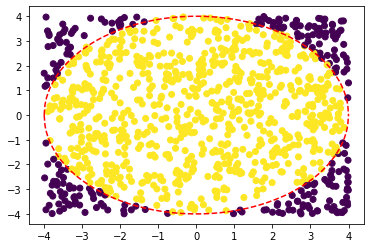

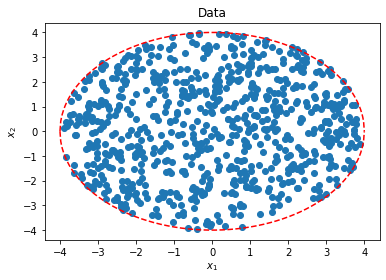

In [4]:
N_sample = 1000
R = 4
x_data = np.random.random(N_sample) * 8 - 4
y_data = np.random.random(N_sample) * 8 - 4

X_data = np.vstack((x_data, y_data)).T

R_data = np.sum(X_data**2, axis = 1)

labels = 2 * (R_data < R**2) - 1

x_plot = np.linspace(-4, 4, 400)

plt.figure()
plt.scatter(X_data[:, 0], X_data[:, 1], c = labels)
plt.plot(x_plot, np.sqrt(16 - x_plot**2), "r--")
plt.plot(x_plot, -np.sqrt(16 - x_plot**2), "r--")
plt.show()

#Get data only in sphere
X = X_data[np.nonzero(R_data < R**2)[0], :]

plt.figure()
plt.title("Data")
plt.scatter(X[:, 0], X[:, 1])
plt.plot(x_plot, np.sqrt(16 - x_plot**2), "r--")
plt.plot(x_plot, -np.sqrt(16 - x_plot**2), "r--")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

     pcost       dcost       gap    pres   dres
 0:  2.3373e-02 -1.9873e+00  2e+03  4e+01  3e-15
 1:  2.4809e-02 -1.9807e+00  2e+01  4e-01  7e-15
 2:  2.7133e-02 -1.5464e+00  2e+00  1e-16  7e-15
 3:  2.7005e-02 -1.5110e-02  4e-02  5e-16  3e-15
 4:  2.5350e-02  1.9684e-02  6e-03  9e-16  1e-15
 5:  2.4515e-02  2.3294e-02  1e-03  6e-16  9e-16
 6:  2.4248e-02  2.3951e-02  3e-04  7e-16  1e-15
 7:  2.4189e-02  2.4052e-02  1e-04  2e-15  9e-16
 8:  2.4157e-02  2.4114e-02  4e-05  1e-15  8e-16
 9:  2.4147e-02  2.4130e-02  2e-05  4e-16  9e-16
10:  2.4142e-02  2.4136e-02  6e-06  5e-16  9e-16
11:  2.4141e-02  2.4139e-02  1e-06  4e-16  9e-16
12:  2.4140e-02  2.4140e-02  5e-07  2e-16  8e-16
13:  2.4140e-02  2.4140e-02  1e-07  1e-15  9e-16
14:  2.4140e-02  2.4140e-02  3e-08  1e-15  9e-16
Optimal solution found.
{'x': <747x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <1494x1 matrix, tc='d'>, 'z': <1494x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.647991720929163e-08, 'relative gap': 1.0969364

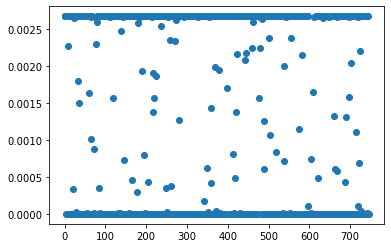

In [5]:
oc_svm_test = OC_SVM('gaussian', upsilon = 0.5)
oc_svm_test.fit(X)

plt.figure()
plt.scatter(np.arange(len(oc_svm_test.alphas)), oc_svm_test.alphas)
plt.show()


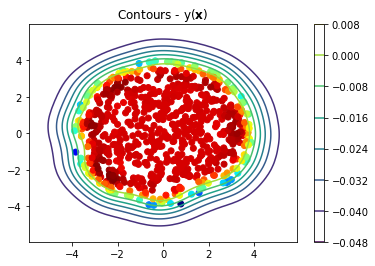

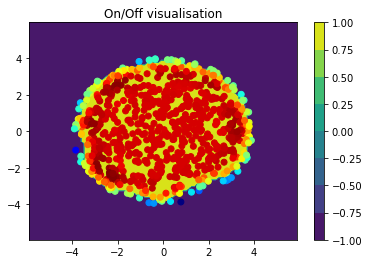

In [6]:
N_grid = 100
X_m, Y_m = np.meshgrid(np.linspace(np.min(X[:, 0]) - 2, np.max(X[:, 0]) + 2, N_grid), np.linspace(np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2, N_grid))

X_grid = np.hstack((X_m.reshape(-1, 1), Y_m.reshape(-1, 1)))

Z = oc_svm_test.predict(X_grid)

plt.figure()
plt.contour(X_m, Y_m, Z.reshape(N_grid, N_grid))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c = oc_svm_test.predict(X), cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title(r"Contours - y($\mathbf{x}$)")

plt.show()

plt.figure()
plt.contourf(X_m, Y_m, np.sign(Z.reshape(N_grid, N_grid)))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c = oc_svm_test.predict(X), cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title("On/Off visualisation")
plt.show()

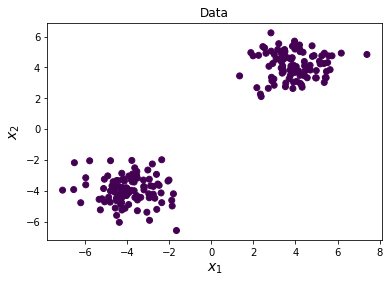

In [7]:
X1 = np.random.randn(100, 2) + np.array([4, 4])
X2 = np.random.randn(100, 2) + np.array([-4, -4])

l1 = np.ones(100)
l2 = np.ones(100)
X = np.vstack((X1, X2))
labels = np.hstack((l1, l2))


plt.figure()
plt.title("Data")
plt.scatter(X[:, 0], X[:, 1], c = labels)
plt.xlabel(r"$x_1$", fontsize = 14)
plt.ylabel(r"$x_2$", fontsize = 14)
plt.show()

     pcost       dcost       gap    pres   dres
 0:  2.9241e-02 -1.0042e+01  1e+01  6e-16  1e-15
 1:  2.9010e-02 -2.1692e-01  2e-01  7e-16  2e-15
 2:  2.6624e-02  7.2694e-03  2e-02  2e-16  3e-16
 3:  2.5531e-02  2.2089e-02  3e-03  1e-16  2e-16
 4:  2.5255e-02  2.4476e-02  8e-04  2e-16  2e-16
 5:  2.5171e-02  2.4906e-02  3e-04  4e-16  2e-16
 6:  2.5137e-02  2.5067e-02  7e-05  6e-16  2e-16
 7:  2.5130e-02  2.5087e-02  4e-05  3e-16  2e-16
 8:  2.5122e-02  2.5110e-02  1e-05  1e-16  2e-16
 9:  2.5119e-02  2.5116e-02  3e-06  4e-16  2e-16
10:  2.5119e-02  2.5118e-02  8e-07  3e-16  2e-16
11:  2.5118e-02  2.5118e-02  2e-08  6e-16  2e-16
Optimal solution found.
{'x': <200x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <400x1 matrix, tc='d'>, 'z': <400x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.2074279618133483e-08, 'relative gap': 8.788097053422149e-07, 'primal objective': 0.025118406047448843, 'dual objective': 0.02511838397316925, 'primal infeasibility': 5.633514488234681e-16, 'dual 

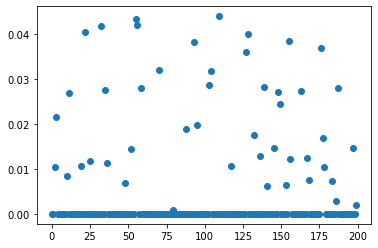

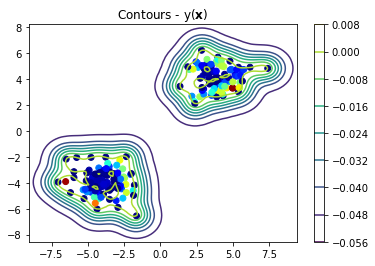

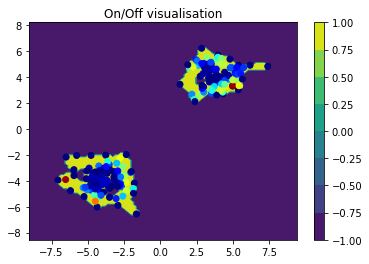

In [8]:
oc_svm_test = OC_SVM('gaussian', upsilon = 0.1)
oc_svm_test.fit(X)

plt.figure()
plt.scatter(np.arange(len(oc_svm_test.alphas)), oc_svm_test.alphas)
plt.show()

N_grid = 100
X_m, Y_m = np.meshgrid(np.linspace(np.min(X[:, 0]) - 2, np.max(X[:, 0]) + 2, N_grid), np.linspace(np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2, N_grid))

X_grid = np.hstack((X_m.reshape(-1, 1), Y_m.reshape(-1, 1)))

Z = oc_svm_test.predict(X_grid)

plt.figure()
plt.contour(X_m, Y_m, Z.reshape(N_grid, N_grid))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c = oc_svm_test.predict(X), cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title(r"Contours - y($\mathbf{x}$)")

plt.show()

plt.figure()
plt.contourf(X_m, Y_m, np.sign(Z.reshape(N_grid, N_grid)))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c = oc_svm_test.predict(X), cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title("On/Off visualisation")
plt.show()